In [646]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [647]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

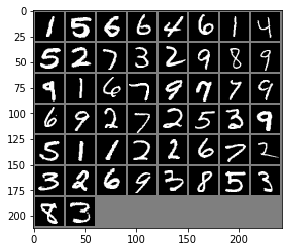

In [648]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN-NG

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [5]:
trainset[0][0].size()

torch.Size([1, 28, 28])

In [530]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, shape, num_samples, init=None):
        super(GeneratorNetwork, self).__init__()
        self.build_net(shape, num_samples, init)
        self.output_dim = shape
    
    def build_net(self, shape, num_samples, init):
        if init is None:
            z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
        else:
            z = torch.from_numpy(init).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        output = F.tanh(self.z_v)
        return output
    
    def parameters(self):
        return [self.z_v]

# class DiscriminatorNetwork(nn.Module):
    
#     def __init__(self, K=2, d=64):
#         super(DiscriminatorNetwork, self).__init__()
#         self.build_net(d, K)
#         self.K = K
#         self.d = d
    
#     def build_net(self, d, K):
#         self.conv1 = nn.Conv2d(1, d, 5, 2, 1)
#         self.conv2 = nn.Conv2d(d, d*2, 5, 2, 1)
#         self.conv2_bn = nn.BatchNorm2d(d*2)
#         self.conv3 = nn.Conv2d(d*2, d*4, 5, 2, 1)
#         self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.linear = nn.Linear(d*4 * 2 * 2, K)
        

#     def forward(self, x):
#         x = F.leaky_relu(self.conv1(x), 0.2)
#         x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
#         x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
#         x = x.view(-1, self.d * 4 * 2 * 2)
#         x =  F.softmax(self.linear(x))
#         return x
class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, K):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(K)
        self.K = K
    
    def build_net(self, K):
        self.conv1 = nn.Conv2d(1, 32, 5, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 5, 2, 1)
#         self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [531]:
from bgan_nogen import BGANNG, FixedSizeDataset

In [532]:
batch_size = 50
z_init = np.copy(trainset[123][0].numpy())[None, :]

In [554]:
prior = FactorizedNormalPrior(std=5.)
disc = DiscriminatorNetwork(K=2)
# disc.load_state_dict(torch.load('disc_weights.pt'))
gen = GeneratorNetwork([1, 28, 28], 1, init=z_init)
bgan = BGANNG(gen, prior, disc, alpha=.01, eta=1e-4, num_data=len(trainset), disc_lr=1e-5, cuda=True)
# gen.apply(weights_init)
# disc.apply(weights_init)
samples = []

Moving generator and discriminator to GPU


In [555]:
# z_init = np.copy(trainset[123][0].numpy())[None, :]
# bgan.generator = GeneratorNetwork([1, 28, 28], 1, init=z_init)
# bgan.generator.cuda()
# plt.imshow(bgan.generator.forward().data.numpy()[0, 0])

In [ ]:
old_samples = None
if isinstance(samples, np.ndarray):
    old_samples = np.copy(samples)
    samples = []
for epoch in range(5000):
    for i, data_ in enumerate(trainloader, 0):

        batch = data_[0].float()
        bgan.step(batch)
        if not i%100:
#             print(i)
            bgan.fake_dataset.append(np.copy(gen.forward().data.numpy()[0, :]))
    if not epoch%1:
        samples.append(np.copy(gen.forward().data.numpy()))
    if not epoch%1:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
if old_samples is not None:
    samples = np.vstack([old_samples, np.array(samples)])
else:
    samples = np.array(samples)

0
0.011384
0.0333798
1
0.00861052
0.0534276
2
0.0111678
0.00985315
3
0.0145035
0.0110326
4
0.0139527
0.0023965
5
0.0344072
0.006416
6
0.0786065
0.0284003


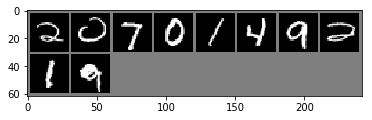

In [649]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [636]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)

In [650]:
samples = [np.array(sample).reshape((1, 1, 28, 28)) for sample in samples]

In [651]:
samples_arr = np.vstack(samples)

In [652]:
samples_arr.shape

(8108, 1, 28, 28)

In [653]:
plt.imshow(1 - (samples_arr[-1, 0] + 1)/2, cmap='gray')

AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

In [654]:
np.max(batch.numpy())

1.0

In [655]:
samples_arr.shape

(8108, 1, 28, 28)

In [643]:
# samples_arr[samples_arr < 0] = -1
# samples_arr[samples_arr > 0] = 1

# fake_samples[fake_samples < 0] = -1
# fake_samples[fake_samples > 0] = 1

In [667]:
# np.where(np.isnan(samples_arr))
# samples_arr = samples_arr[:4594]

In [669]:
thinned_samples = []
thinning_rate = 10
num_thinned = int(len(samples_arr) / thinning_rate)
indices = np.arange(num_thinned) * thinning_rate
thinned_samples = samples_arr[indices]

# for i, sample in samples_arr:

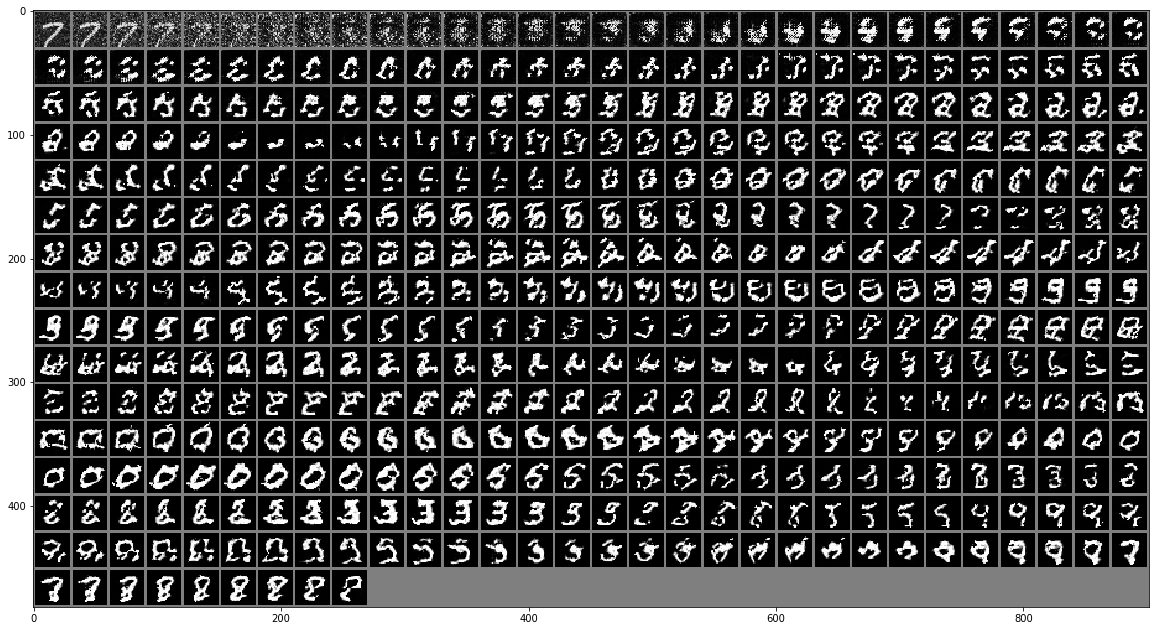

In [670]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(thinned_samples), nrow=30))

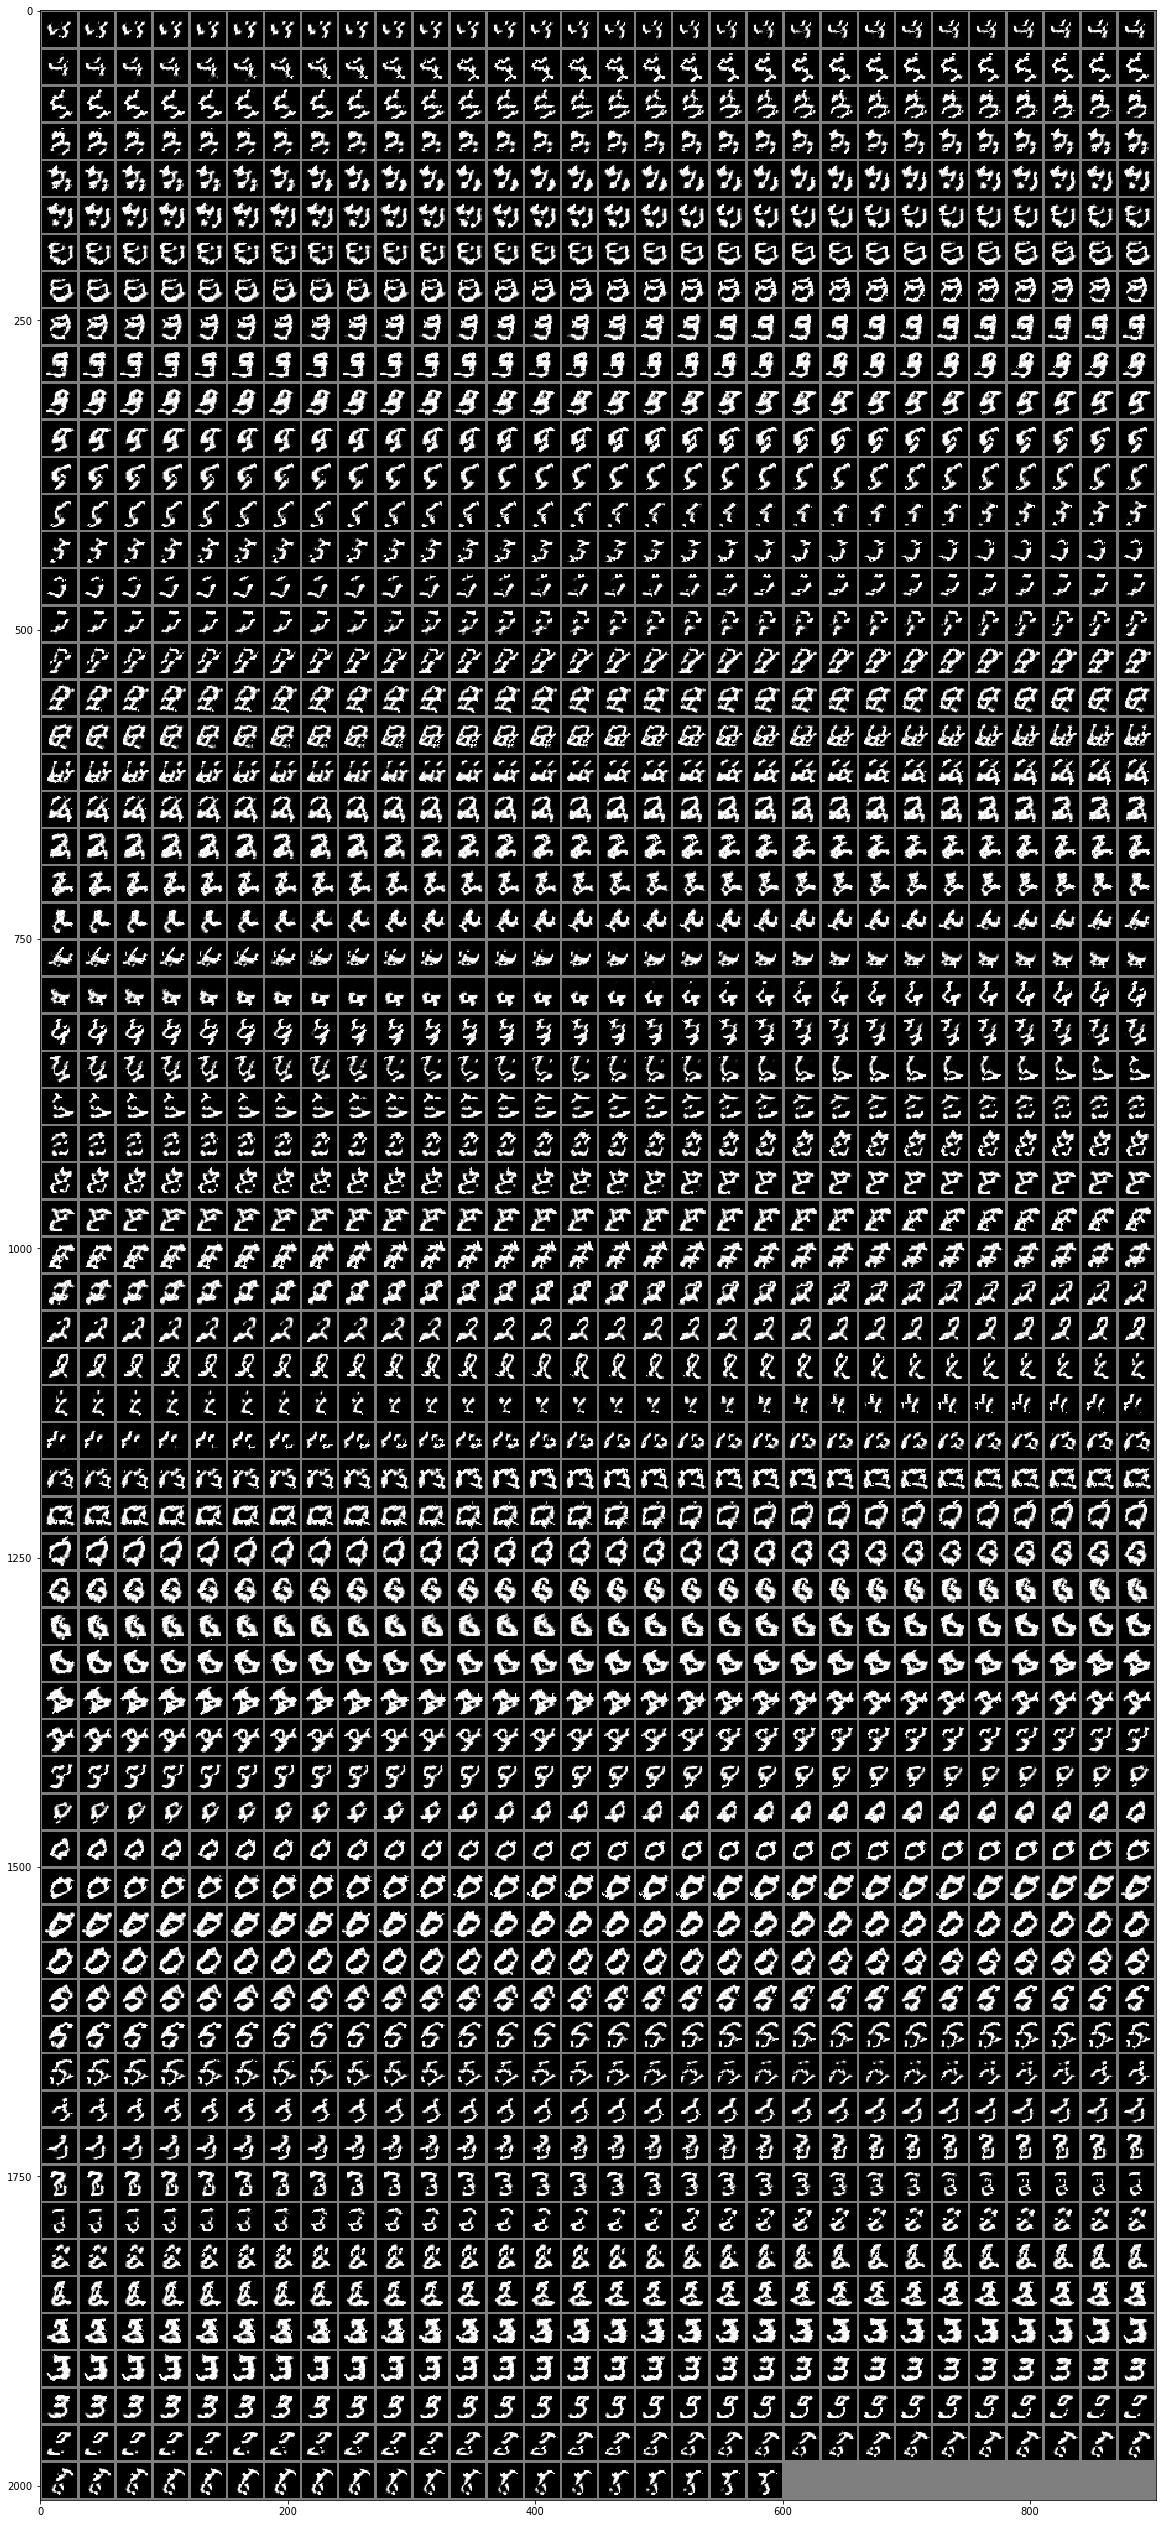

In [660]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[-6000:-4000]), nrow=30))


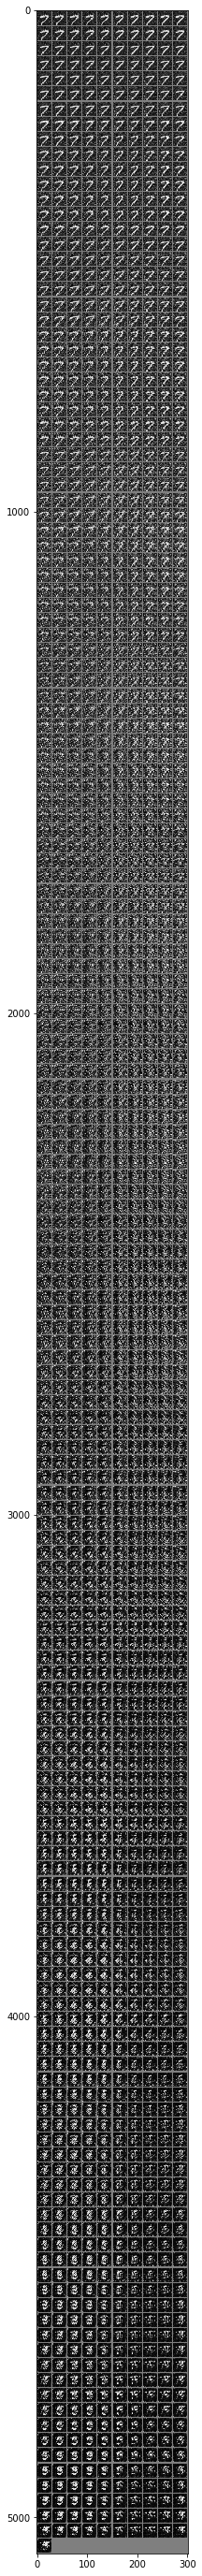

In [595]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(fake_samples[:]), nrow=10))


In [596]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())[:, 0]

In [597]:
sample_probs

Variable containing:
 0.0300
 0.0295
 0.0286
 0.0286
 0.0285
 0.0284
 0.0285
 0.0284
 0.0279
 0.0277
 0.0272
 0.0273
 0.0278
 0.0287
 0.0297
 0.0298
 0.0296
 0.0299
 0.0318
 0.0328
 0.0347
 0.0343
 0.0363
 0.0402
 0.0392
 0.0391
 0.0389
 0.0394
 0.0408
 0.0410
 0.0414
 0.0400
 0.0403
 0.0416
 0.0436
 0.0454
 0.0483
 0.0524
 0.0567
 0.0611
 0.0630
 0.0660
 0.0691
 0.0711
 0.0743
 0.0749
 0.0761
 0.0811
 0.0846
 0.0877
 0.0915
 0.0955
 0.1006
 0.1043
 0.1104
 0.1155
 0.1196
 0.1271
 0.1321
 0.1370
 0.1460
 0.1539
 0.1666
 0.1780
 0.1839
 0.1950
 0.2089
 0.2219
 0.2337
 0.2567
 0.2818
 0.3071
 0.3339
 0.3562
 0.3836
 0.4163
 0.4603
 0.4914
 0.5432
 0.5826
 0.6137
 0.6552
 0.6889
 0.7094
 0.7331
 0.7545
 0.7810
 0.8083
 0.8269
 0.8453
 0.8603
 0.8752
 0.8877
 0.8983
 0.9071
 0.9166
 0.9235
 0.9290
 0.9340
 0.9376
[torch.cuda.FloatTensor of size 100 (GPU 0)]

In [598]:
disc(Variable(trainset[71][0][None, :].cuda()))[:, 0]

Variable containing:
 0.8550
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [599]:
disc(Variable(batch).cuda())[:, 0]

Variable containing:
 0.8145
 0.8752
 0.9035
 0.9062
 0.8250
 0.7478
 0.8422
 0.8651
 0.8573
 0.6971
 0.9048
 0.8441
 0.8967
 0.8888
 0.8174
 0.8251
 0.8884
 0.7921
 0.8161
 0.7041
 0.8959
 0.8627
 0.8316
 0.8557
 0.9078
 0.8696
 0.8594
 0.7684
 0.8861
 0.8110
 0.7876
 0.8911
 0.8486
 0.7928
 0.8446
 0.9204
 0.8663
 0.8930
 0.8537
 0.8246
 0.7370
 0.8738
 0.7925
 0.9020
 0.7980
 0.6575
 0.7702
 0.8137
 0.7675
 0.8422
[torch.cuda.FloatTensor of size 50 (GPU 0)]

In [294]:
# torch.save(bgan.discriminator.state_dict(), 'disc_weights.pt')
# disc.load_state_dict(torch.load('disc_weights.pt'))
# for param1, param2 in list(zip(disc.parameters(), bgan.discriminator.parameters())):
#     print(np.linalg.norm(param1.cpu().data.numpy() - param2.cpu().data.numpy()))